In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [3]:
import torch
import numpy as np
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
from inpainting.visualizations import samples as vis
from inpainting.visualizations.digits import img_with_mask
import pandas as pd
from inpainting.evaluation import evaluation as ev
from tqdm import tqdm
from itertools import chain
from inpainting.evaluation.frechet_models import MNISTNet
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD
from torch.nn import CrossEntropyLoss
from sklearn.metrics import accuracy_score
from inpainting.evaluation import fid
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader

In [4]:
mnist_experiments_paths = {
    "misgan": Path("../results/mnist/misgan/"),
    "torch_mfa": Path("../../gmm_missing/models/mnist"),
    "gmm_fullconv": Path("../results/mnist/long_trainings/fullconv_v1"),
    "gmm_linear_heads": Path("../results/mnist/long_trainings/linear_v1"),
}

celeba_32_experiments_paths = {
    "gmm_linear_heads" = Path("../results/celeba/linear_heads/32x32/scripted_v2_after_fix"),
    "gmm_fullconv" = Path("../results/celeba/fullconv/32x32/scripted_v2_after_fix"),
    "torch_mfa" = Path("../../gmm_missing/models/celeba_32_32")
}

In [5]:
experiments_results = dict()

for (name, path) in experiments_paths.items():
    with (path / "val_predictions.pkl").open("rb") as f:
        experiments_results[name] = pickle.load(f)

In [6]:
x, j, p, m ,a, d, y = experiments_results["torch_mfa"][0]

In [7]:
# [t.shape for t in [x, j, p, m, a, d, y]]

In [8]:
experiments_images = dict()

for (name, results) in experiments_results.items():
    experiments_images[name] = [(ev.outputs_to_images(*r), r[-1]) for r in results]

# NLL and MSE

In [9]:
ml_metrics = {
    name: [
        (ev.loss_like_metrics(res), res)
        for res in results
    ]
    for name, results in tqdm(experiments_results.items())
}

100%|██████████| 4/4 [02:34<00:00, 38.64s/it]


In [10]:
ml_metrics_df = pd.DataFrame([
    {
        "imputer_model": model,
        "smieja_nll": m[1][-1][1] if len(m[1][-1].shape) > 0 else None,
        **m[0]
    }
    for model, metrics in ml_metrics.items()
    for m in metrics
])

ml_metrics_df

,imputer_model,smieja_nll,nll,mse
0,misgan,NaN,0.000000,1.827353
1,misgan,NaN,0.000000,20.409973
2,misgan,NaN,0.000000,21.382469
3,misgan,NaN,0.000000,22.752024
4,misgan,NaN,0.000000,34.990574
...,...,...,...,...
39995,gmm_linear_heads,NaN,-145.105545,14.012247
39996,gmm_linear_heads,NaN,-151.375305,25.087900
39997,gmm_linear_heads,NaN,-475.694794,7.355198
39998,gmm_linear_heads,NaN,-579.062744,4.654380


In [11]:
mfa_df = ml_metrics_df[ml_metrics_df.imputer_model == "torch_mfa"]
mfa_df

,imputer_model,smieja_nll,nll,mse
10000,torch_mfa,170.087860,-170.087921,2.327581
10001,torch_mfa,56.930603,-56.930515,19.517910
10002,torch_mfa,37.943298,-37.942802,7.148335
10003,torch_mfa,-47.730408,47.730461,32.189854
10004,torch_mfa,-366.853516,366.853424,26.373322
...,...,...,...,...
19995,torch_mfa,66.430405,-66.430397,7.627316
19996,torch_mfa,-257.578613,257.578613,30.835539
19997,torch_mfa,140.843964,-140.843903,4.530435
19998,torch_mfa,147.767395,-147.767319,3.930964


In [12]:
ml_metrics_df.groupby("imputer_model").agg(["mean", "std"])

smieja_nll                     nll                    mse  \
                       mean         std        mean         std       mean   
imputer_model                                                                
gmm_fullconv            NaN         NaN -165.363661  318.317436  14.531253   
gmm_linear_heads        NaN         NaN -244.811695  363.773790  12.967024   
misgan                  NaN         NaN    0.000000    0.000000  27.061036   
torch_mfa        -58.107221  352.561241   58.107220  352.561243  18.593453   

                             
                        std  
imputer_model                
gmm_fullconv       6.858685  
gmm_linear_heads   6.507890  
misgan            14.425505  
torch_mfa         14.808086

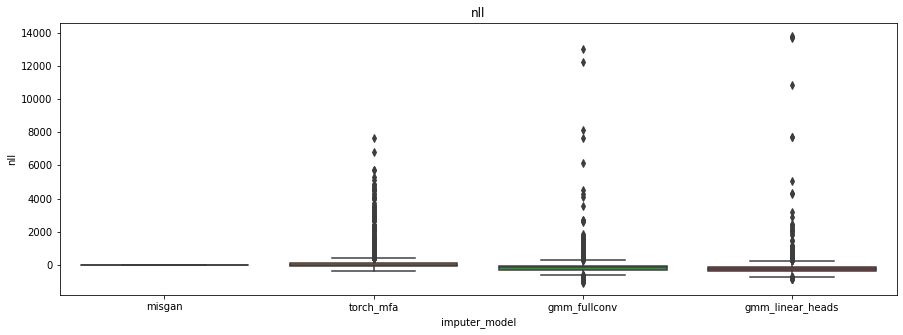

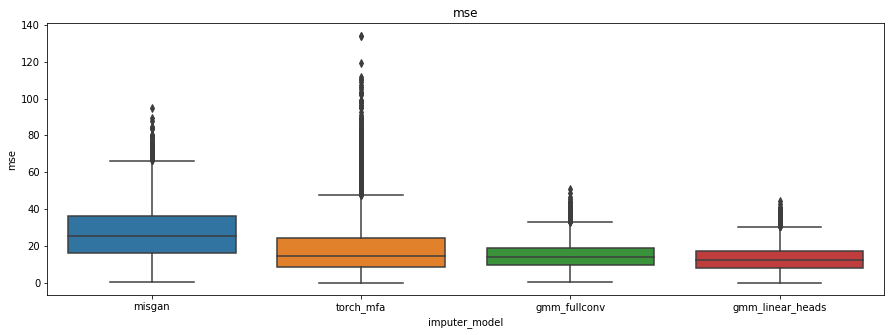

In [13]:
for metric in ["nll", "mse"]:
    plt.figure(figsize=(15, 5))
    plt.title(metric)
    sns.boxplot(
        data=ml_metrics_df,
        y=metric,
        # x="img_kind",
        x="imputer_model"
    )
    plt.show()

# Worst and best NLL cases for every model

misgan worst 5


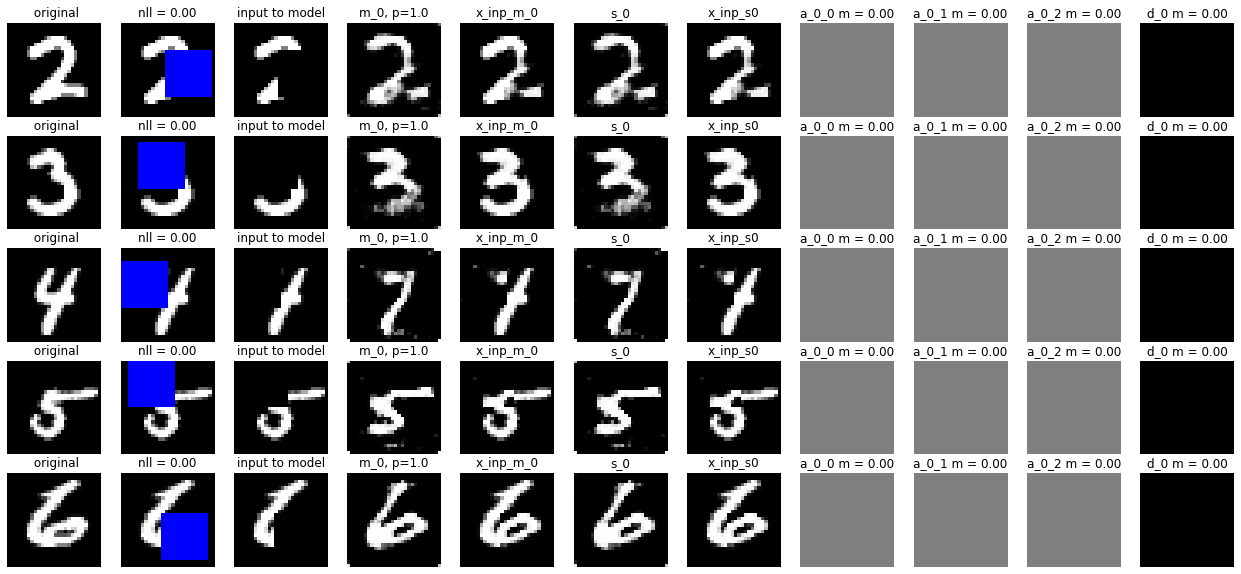

misgan best 5


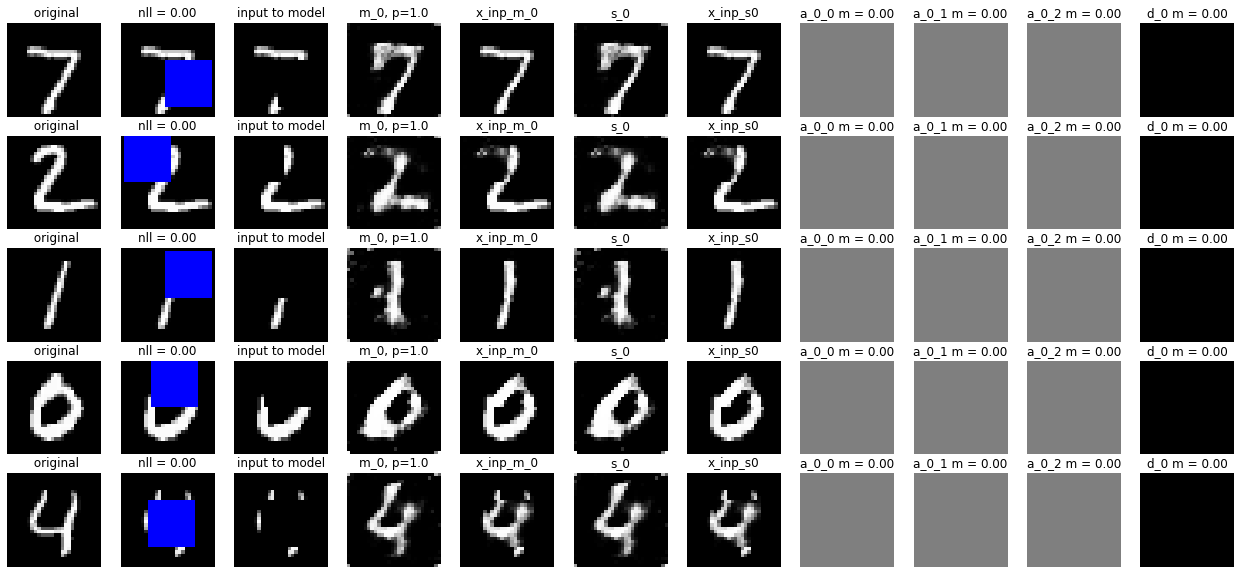

torch_mfa worst 5


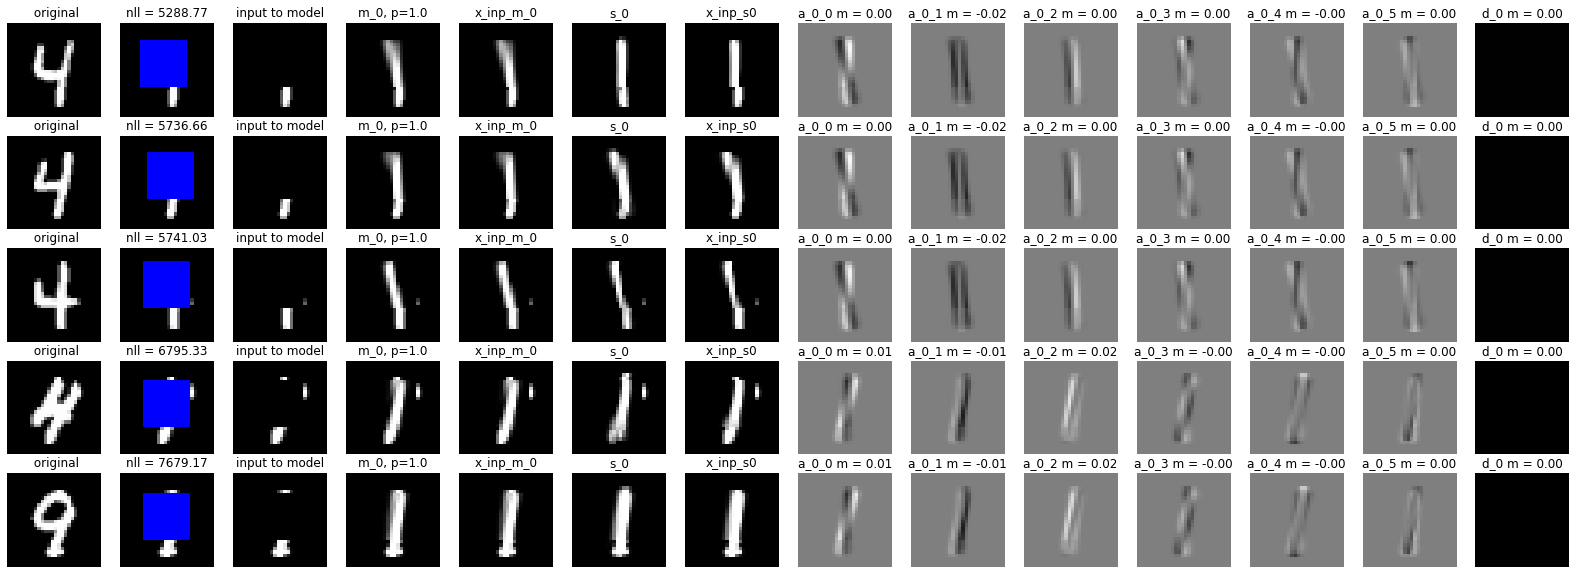

torch_mfa best 5


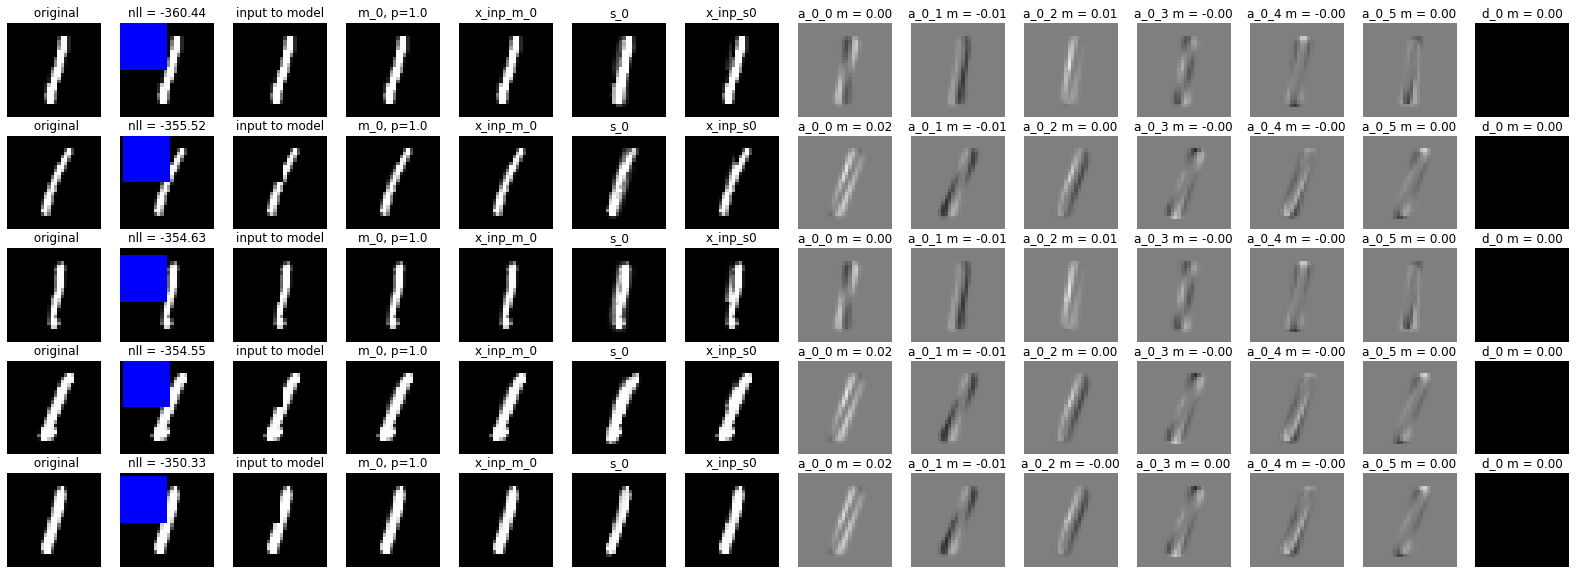

gmm_fullconv worst 5


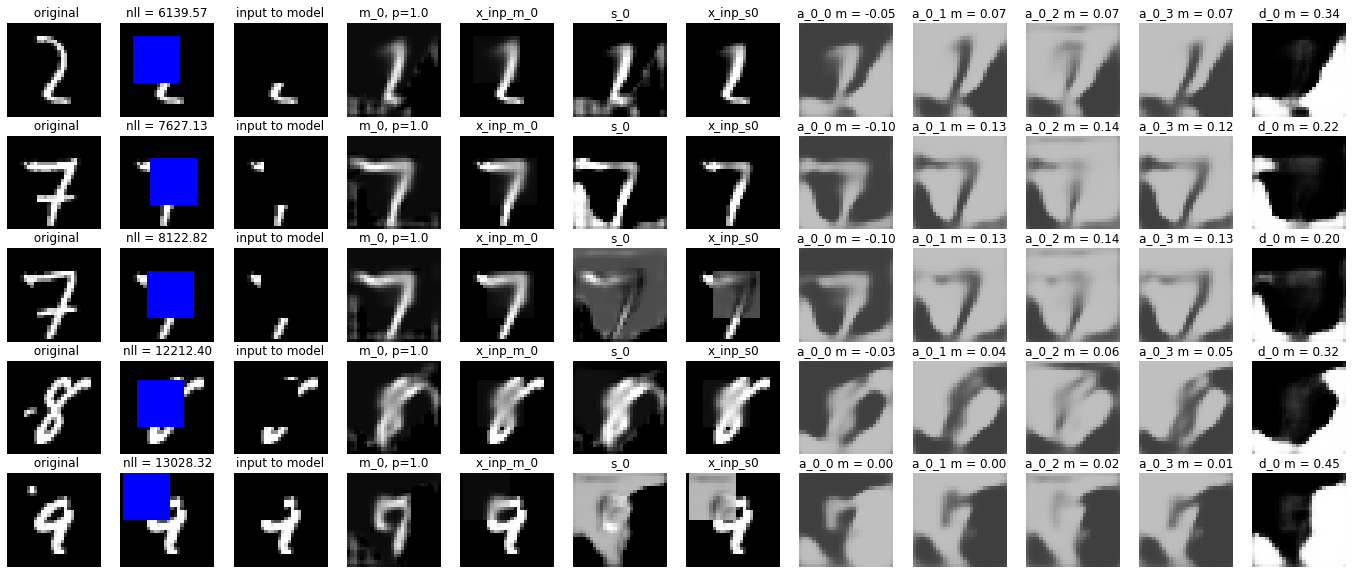

gmm_fullconv best 5


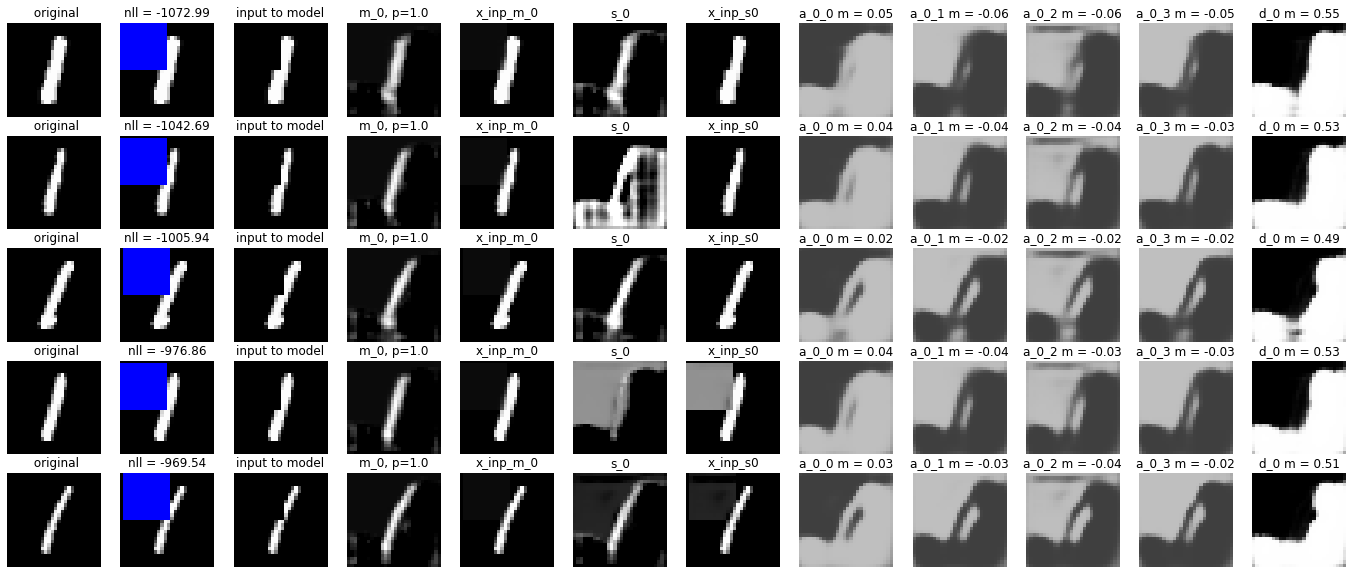

gmm_linear_heads worst 5


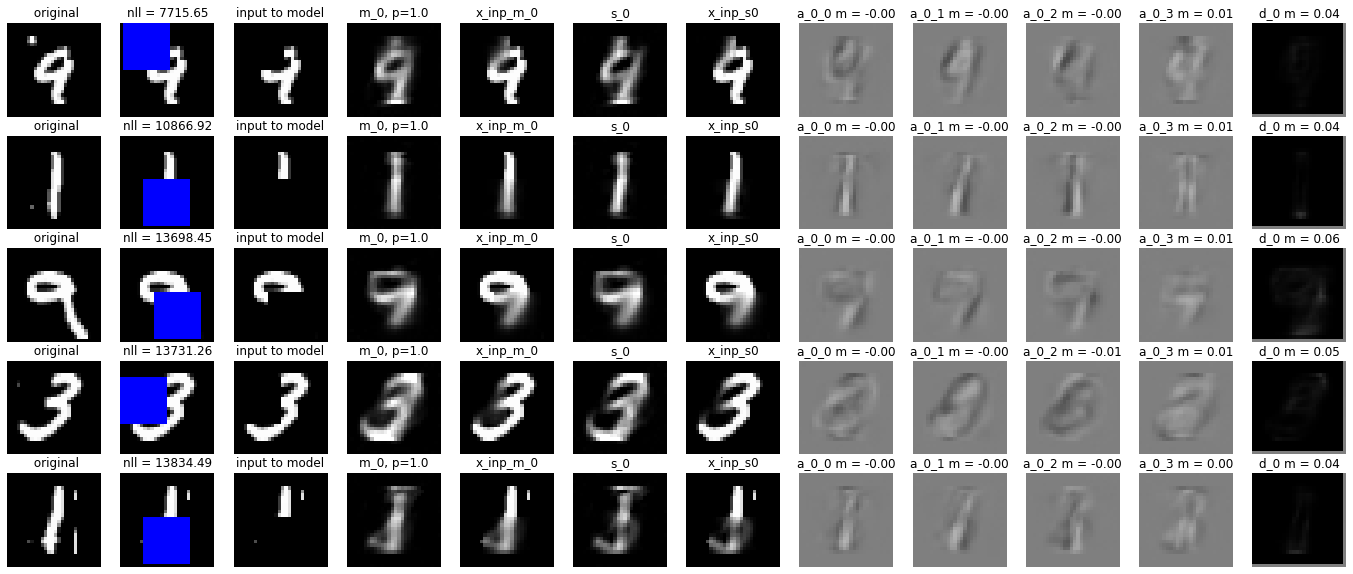

gmm_linear_heads best 5


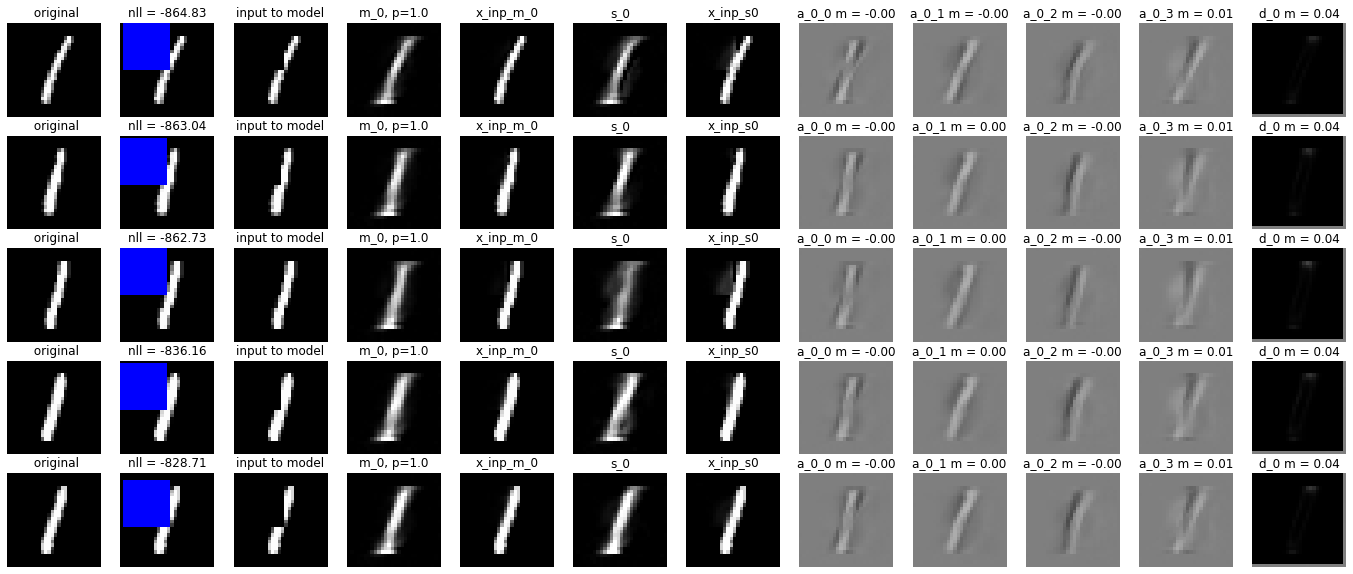

In [14]:
n = 5
for model, metrics_with_cases in ml_metrics.items():
    metrics_with_cases = sorted(
        metrics_with_cases, key = lambda m_c: m_c[0]["nll"]
    )
#     metrics_with_cases = [
#         m for m in metrics_with_cases if m[1][-1] != 1
#     ] 
    for (name, mwc) in [
        ("worst", metrics_with_cases[-n:]),
        ("best", metrics_with_cases[:n])
    ]:
        print(model, name, n)
        row_len = vis.row_length(
            *metrics_with_cases[0][1]
        )
        fig, ax = plt.subplots(nrows=n, ncols=row_len, figsize=(2* row_len, n * 2))
        for i, (m, c) in enumerate(mwc):
            vis.visualize_sample(
                *c,
                ax_row=ax[i]
            )
            ax[i, 1].set_title(
                f"nll = {m['nll']:.2f}"
            )
        plt.show()



# Skimage metrics

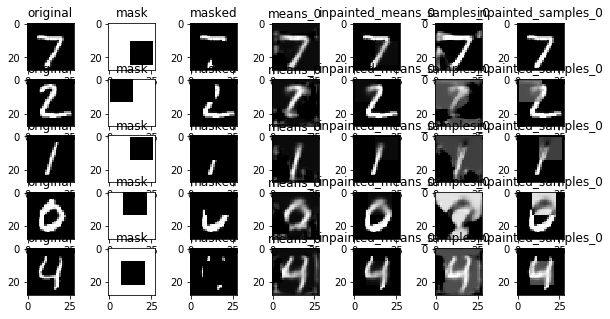

In [15]:
def plot_exp_images(images_dicts, figsize=(15,15)):
    width = len(images_dicts[0][0])
    height = len(images_dicts)
    fig, ax = plt.subplots(height,width, figsize=figsize)
    for i, (imgs, label) in enumerate(images_dicts):
        for j, (k, v) in enumerate(imgs.items()):
            ax[i][j].imshow(v.squeeze(), cmap="gray", vmin=0, vmax=1)
            ax[i][j].set_title(k)

plot_exp_images(experiments_images["gmm_fullconv"][:5], figsize=(10, 5))

In [16]:
experiments_metrics = {
    name: [
        {
            "metrics": ev.images_metrics(img_dict),
            "label": label
        }
        for (img_dict, label) in img_dicts
    ]
    for name, img_dicts in experiments_images.items()
}

/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)
/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/site-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)
../inpainting/evaluation/evaluation.py:82: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  "peak_signal_noise_ratio": lambda i1, i2,: peak_signal_noise_ratio(i1, i2)


In [17]:
per_image_metrics_df = pd.DataFrame([
    {
        "imputer_model": model,
        "label": label_metric["label"],
        **metric
    }
    for model, label_metrics in experiments_metrics.items()
    for label_metric in label_metrics
    for metric in label_metric["metrics"] #if metric["img_kind"] #in ["inpainted_means_0", "inpainted_samples_0"]
])
per_image_metrics_df

,imputer_model,label,img_kind,structural_similarity,peak_signal_noise_ratio
0,misgan,7,original,1.000000,inf
1,misgan,7,mask,0.031003,1.441435
2,misgan,7,masked,0.729407,14.963664
3,misgan,7,means_0,0.597701,14.245572
4,misgan,7,inpainted_means_0,0.977157,26.324935
...,...,...,...,...,...
279995,gmm_linear_heads,6,masked,0.628482,11.051377
279996,gmm_linear_heads,6,means_0,0.587709,12.746711
279997,gmm_linear_heads,6,inpainted_means_0,0.862934,17.307263
279998,gmm_linear_heads,6,samples_0,0.678046,13.586164


In [18]:
per_image_metrics_df.drop("label", axis=1).groupby(
    ["imputer_model", "img_kind"]
).agg(
    lambda pts: "{0:.2f} ± {1:.2f}".format(np.mean(pts), np.std(pts) )
     ).reset_index().to_csv("ssim_psnr.csv")

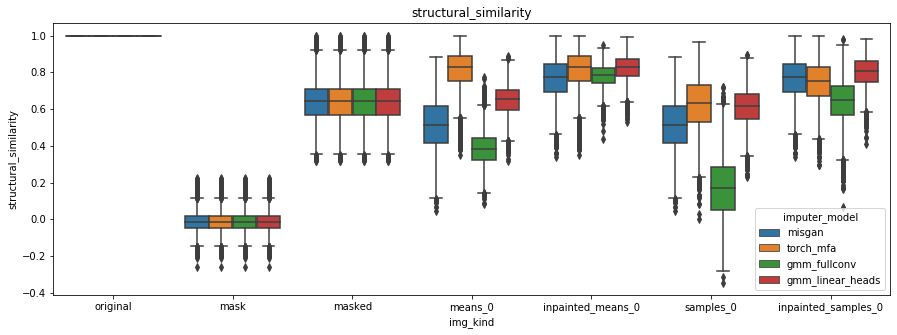

/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1291: RuntimeWarning: invalid value encountered in double_scalars
  stats['iqr'] = q3 - q1
/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1291: RuntimeWarning: invalid value encountered in double_scalars
  stats['iqr'] = q3 - q1
/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/sit

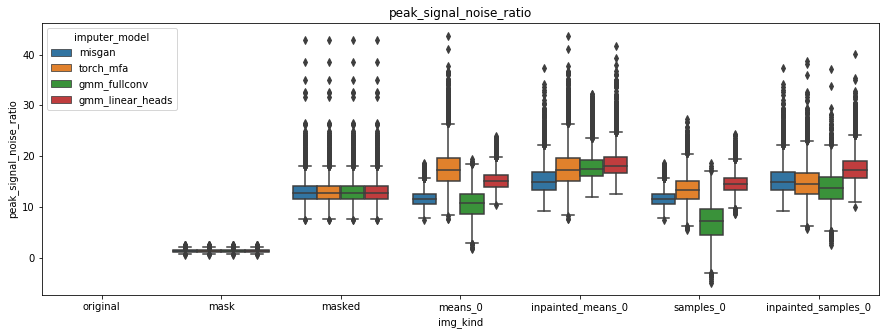

In [19]:
for metric in ["structural_similarity", "peak_signal_noise_ratio"]:
    plt.figure(figsize=(15, 5))
    plt.title(metric)
    sns.boxplot(
        data=per_image_metrics_df,
        y=metric,
        x="img_kind",
        hue="imputer_model"
    )
    plt.show()

# Example inpaintings of the same digit

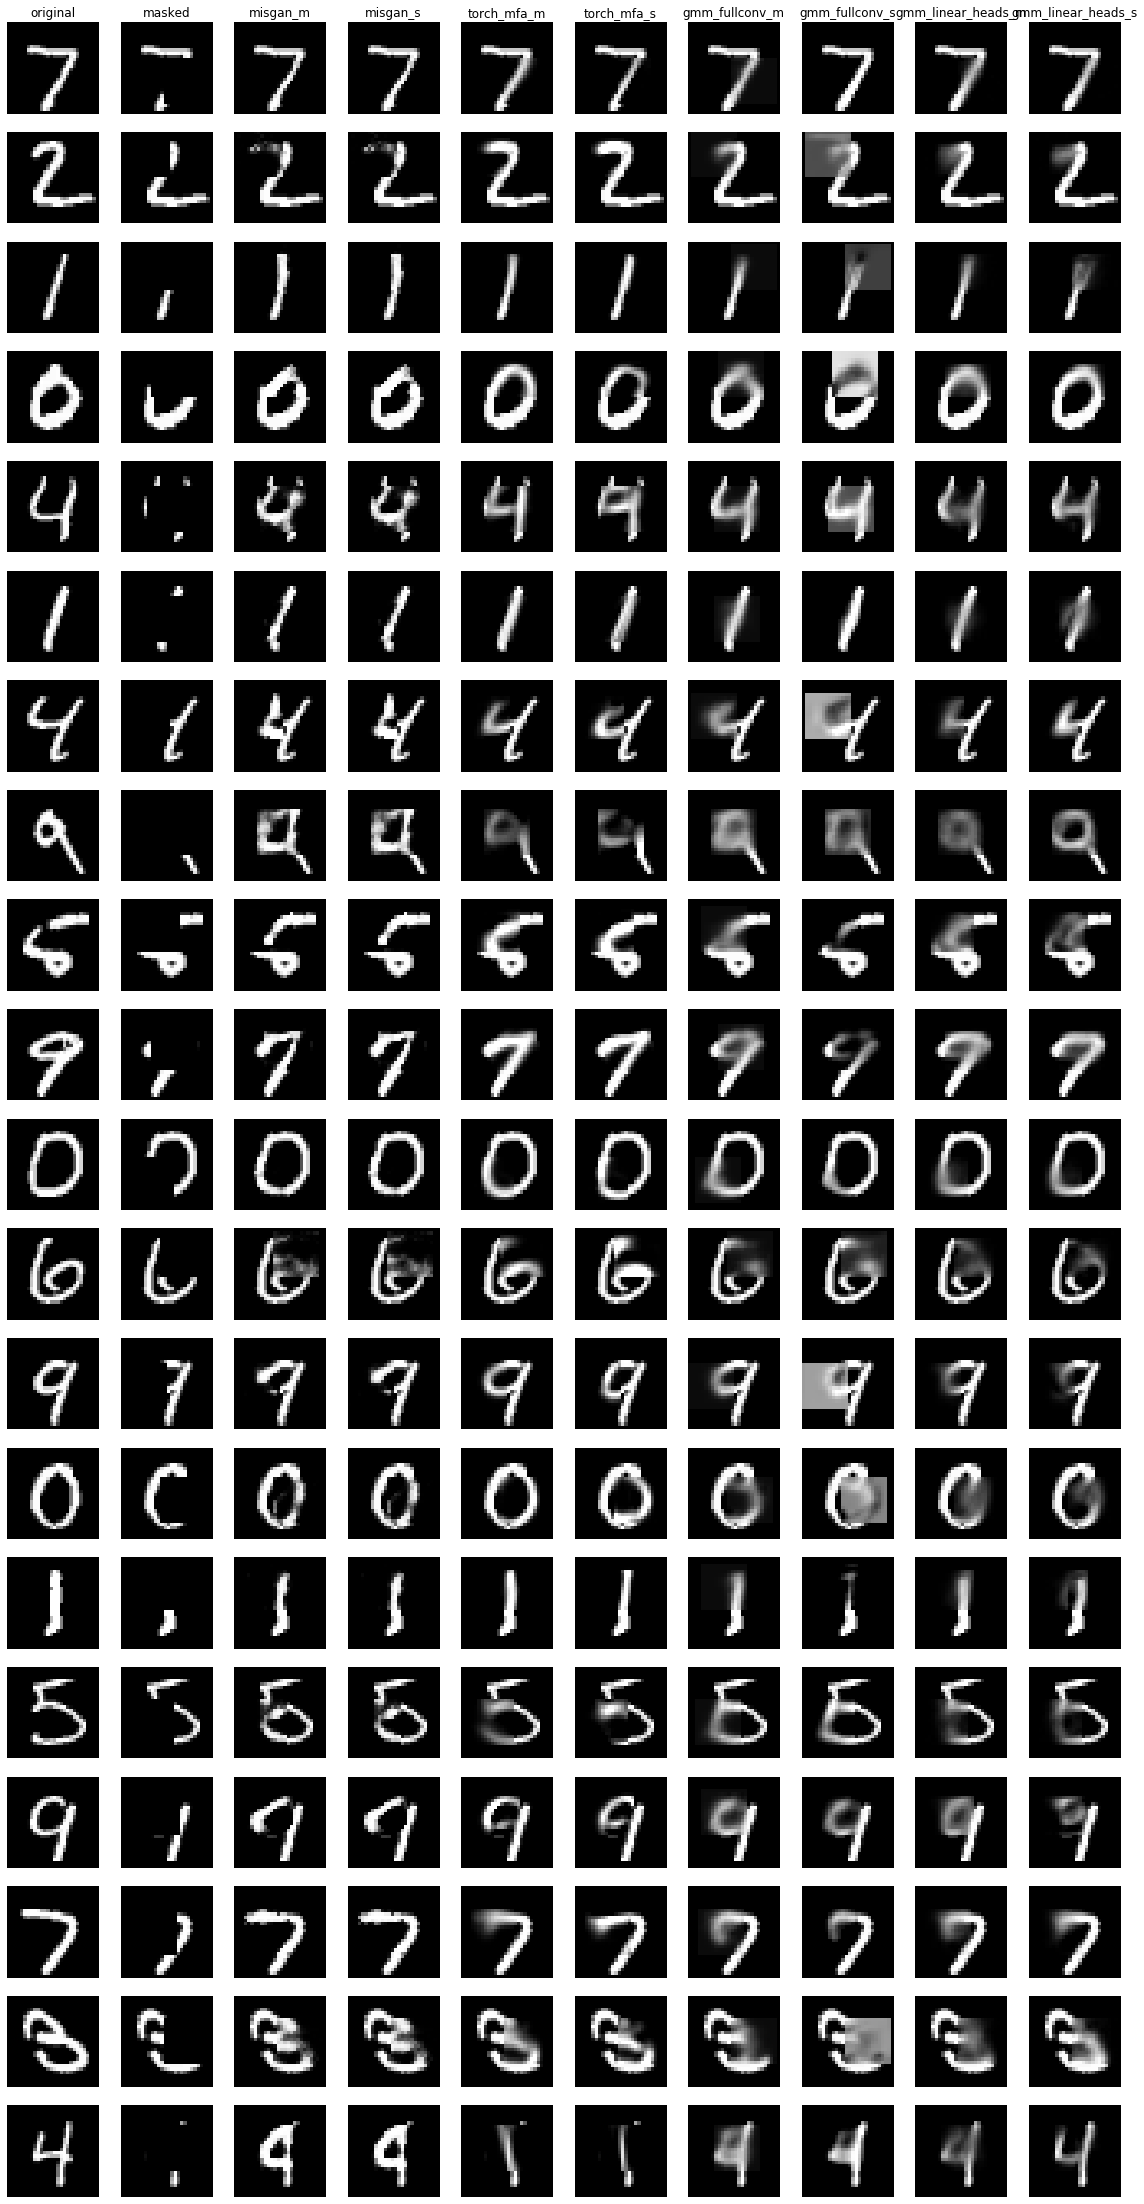

In [31]:
n_rows = 20
n_cols = (len(experiments_images.keys())*2) + 2
fig, ax = plt.subplots(
    nrows=n_rows, 
    ncols=n_cols,
    figsize=(n_cols*2, n_rows*2)
)
for i, (exp_name, imgs) in enumerate(experiments_images.items()):
    for c, img_name, brief_name in [
        ((2*i) + 2, "inpainted_means_0", "m"),
        ((2*i) + 3, "inpainted_samples_0", "s")        
    ]:
        ax[0, c].set_title(f"{exp_name}_{brief_name}")
        for j in range(n_rows):
            ax[j,c].imshow(imgs[j][0][img_name].squeeze(), vmin=0, vmax=1, cmap="gray")
            ax[j,c].axis("off")
    if i == 0:
        for c, img_name in [
            (0, "original"),
            (1, "masked")        
        ]:
            ax[0, c].set_title(f"{img_name}")
            for j in range(n_rows):
                ax[j,c].imshow(imgs[j][0][img_name].squeeze(), vmin=0, vmax=1, cmap="gray")
                ax[j,c].axis("off")

# Frechet distance

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

ds_train = MNIST(Path.home() / "uj" / "data", train=True, download=True, transform=ToTensor())
ds_val = MNIST(Path.home() / "uj" / "data", train=False, download=True, transform=ToTensor())

dl_train = DataLoader(ds_train, 1024, shuffle=True)
dl_val = DataLoader(ds_val, 256, shuffle=False)

classifier = MNISTNet()
opt = Adam(classifier.parameters(), 4e-3)
loss_fn = CrossEntropyLoss()

classifier.to(device)
for i in range(5):
    classifier.train()
    for X, y in tqdm(dl_train):
        opt.zero_grad()
        X, y = [t.to(device) for t in [X, y]]
        y_pred, _ = classifier(X)
        loss = loss_fn(y_pred, y)
        loss.backward()
        opt.step()
    classifier.eval()
    accs = []
    for (X,y ) in dl_val:
        X, y = [t.to(device) for t in [X, y]]
        y_pred, _ = classifier(X)
        logits = y_pred.argmax(1)
        accs.append(accuracy_score(y.cpu().numpy(), logits.cpu().numpy()))
    print(i, np.mean(accs))

  0%|          | 0/59 [00:00<?, ?it/s]

cpu


  0%|          | 0/59 [00:00<?, ?it/s]

0 0.81005859375


  0%|          | 0/59 [00:00<?, ?it/s]

1 0.84921875


  0%|          | 0/59 [00:00<?, ?it/s]

2 0.86494140625


  0%|          | 0/59 [00:00<?, ?it/s]

3 0.86884765625


100%|██████████| 59/59 [04:32<00:00,  4.62s/it]


4 0.86982421875


In [22]:
def images_loader(
    images,
    batch_size = 256
):
    return DataLoader(
        TensorDataset(
            torch.Tensor([
                img.transpose(2, 0, 1)
                for img in images
            ])
        ),
        batch_size=batch_size
    )
    

def frechet_distance(
    images_loader_1,
    images_loader_2,
    model=classifier
):
    (mu_1, s_1), (mu_2, s_2) = [
        fid.calculate_activation_statistics(
            il,
            len(il.dataset),
            model,
            feature_dim=128,
        )
        for il in [images_loader_1, images_loader_2]
    ]
    return fid.calculate_frechet_distance(
        mu_1, s_1, mu_2, s_2
    )

def grouped_by_kinds(images_dicts):
    return {
        k: [
            i_d[k] for (i_d, _) in images_dicts
        ]
        for k in images_dicts[0][0].keys()
    }
    


In [23]:
experiments_images_by_kinds = {
    name: grouped_by_kinds(img_dicts)
    for name, img_dicts in experiments_images.items()
}

In [24]:
frechet_dists = {
    name: {
        kind: frechet_distance(
            images_loader(kind_to_images["original"]),
            images_loader(images)
            )
        for kind, images in kind_to_images.items()
    }
    for name, kind_to_images in experiments_images_by_kinds.items()
}

In [25]:
frechet_dists_df = pd.DataFrame([
    {
        "imputer_model": name,
        "kind": kind,
        "frechet_distance": fd
    }
    for name, kind_to_fd in frechet_dists.items()
    for kind, fd in kind_to_fd.items()
])

frechet_dists_df

,imputer_model,kind,frechet_distance
0,misgan,original,-7.105427e-15
1,misgan,mask,2.789951e+01
2,misgan,masked,6.409780e+00
3,misgan,means_0,1.921869e+00
4,misgan,inpainted_means_0,5.710478e-01
5,misgan,samples_0,1.921869e+00
6,misgan,inpainted_samples_0,5.710478e-01
7,torch_mfa,original,-7.105427e-15
8,torch_mfa,mask,2.789951e+01
9,torch_mfa,masked,6.409780e+00


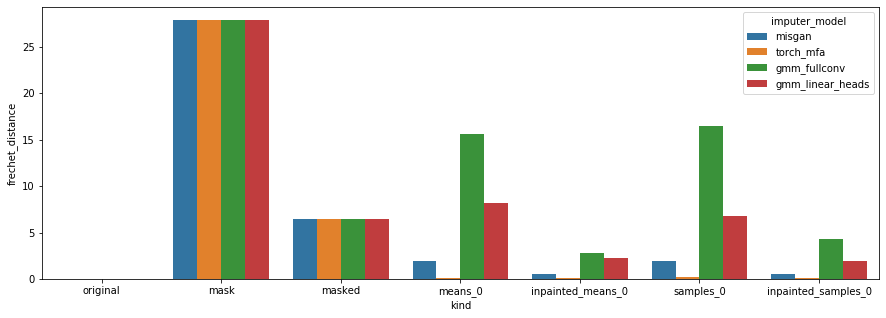

In [26]:
plt.figure(figsize=(15, 5))
sns.barplot(
    data=frechet_dists_df,
    y="frechet_distance",
    x="kind",
    hue="imputer_model",
)

In [27]:
frechet_dists_df.to_csv("frechet_dists_tmp.csv")